In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import warnings
import prophet
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")
import keras

In [2]:
data = pd.read_csv('../data/regional_multivariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/multivariate/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/multivariate/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/multivariate/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/multivariate/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/multivariate/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [40]:
def process(df):
    x = df.drop(columns = ['new_confirmed', 'region'] + [col for col in df.columns if col[0].isdigit()])
    lag1df = x.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df = df[['new_confirmed'] + [col for col in df.columns if col[0].isdigit()]].join(lag1df)
    return df.fillna(0)

## Baseline

21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing
21:13:19 - cmdstanpy - INFO - Chain [1] start processing
21:13:19 - cmdstanpy - INFO - Chain [1] done processing


East North Central
MASE:  0.34695624307823814
Train MASE:  0.4967414280277122
RMSE:  4713.166912503407
MAE:  3007.5071224270355


21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


East South Central
MASE:  0.36660467737626234
Train MASE:  0.6817893449371788
RMSE:  2145.1377082850936
MAE:  1329.2777996638238


21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mid-Atlantic
MASE:  1.4975260619556687
Train MASE:  0.8463437936951299
RMSE:  4896.7728560583455
MAE:  3418.482832156538


21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


Mountain
MASE:  0.9912706237435428
Train MASE:  0.753153679050219
RMSE:  5176.497308868111
MAE:  3312.9948310242908


21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing


New England
MASE:  0.7306855451189825
Train MASE:  0.6700545517451317
RMSE:  2768.1754369913588
MAE:  1977.6404584873171


21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing


Pacific
MASE:  1.145079663420777
Train MASE:  0.670588890142328
RMSE:  13056.551445988174
MAE:  8214.668538479846


21:13:21 - cmdstanpy - INFO - Chain [1] start processing
21:13:21 - cmdstanpy - INFO - Chain [1] done processing


South Atlantic
MASE:  0.6456167222172006
Train MASE:  0.6929624915957479
RMSE:  11514.56541944507
MAE:  7484.941711294796


21:13:22 - cmdstanpy - INFO - Chain [1] start processing
21:13:22 - cmdstanpy - INFO - Chain [1] done processing


West North Central
MASE:  0.6756792005229146
Train MASE:  0.6277823476903323
RMSE:  3619.589830260196
MAE:  2319.230890889612
West South Central
MASE:  0.45301487536487056
Train MASE:  0.7662505031907808
RMSE:  3414.928733398591
MAE:  2200.2480109911066


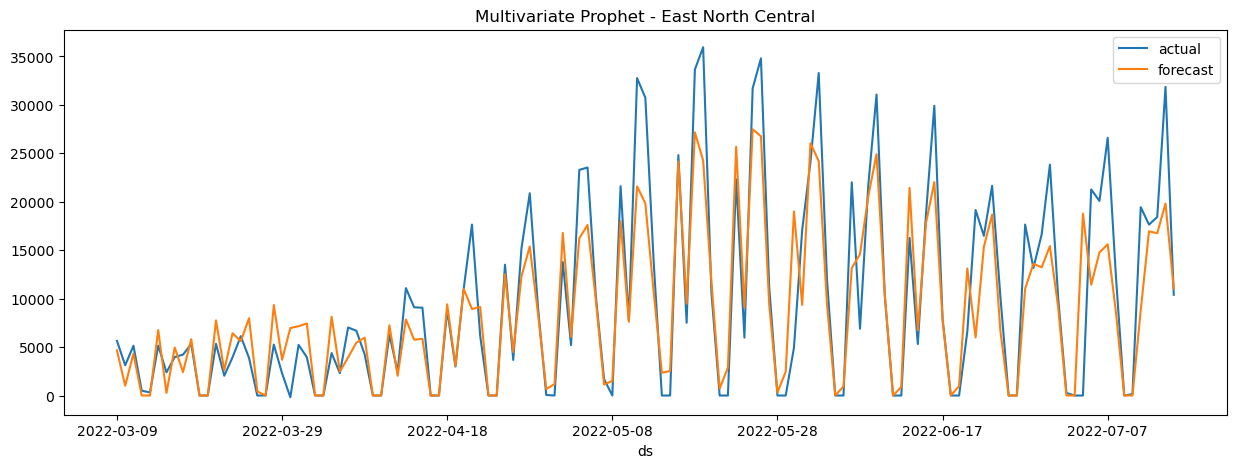

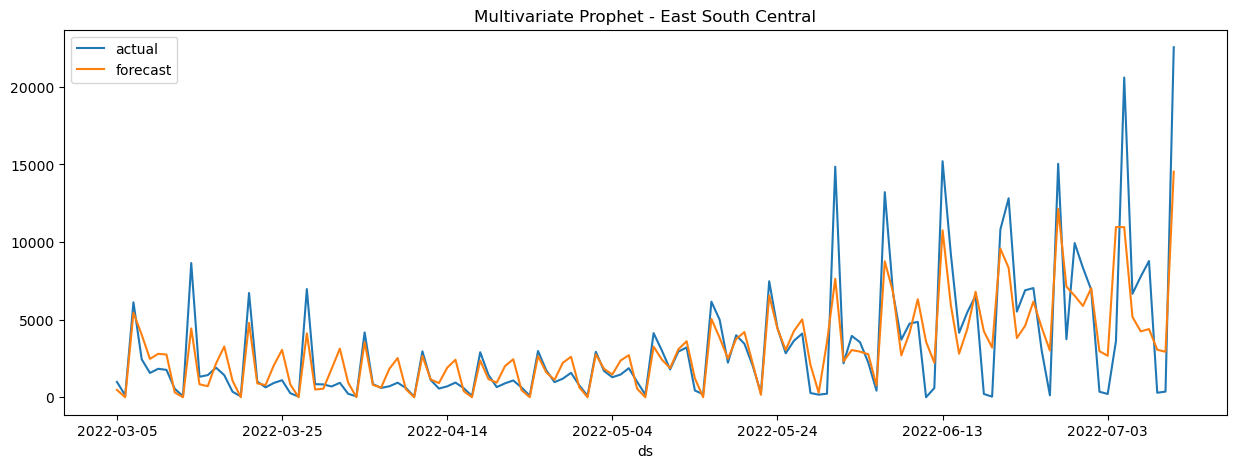

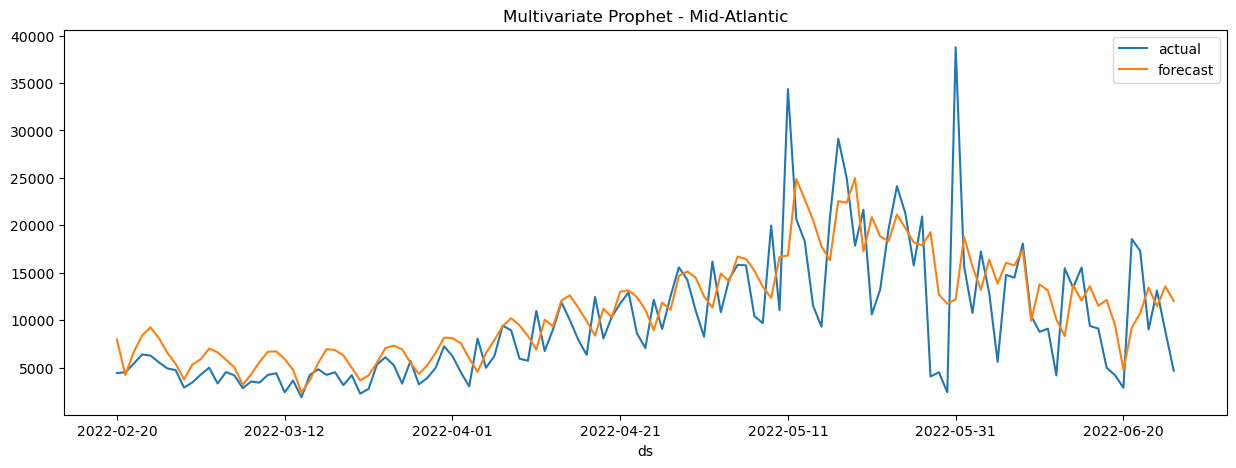

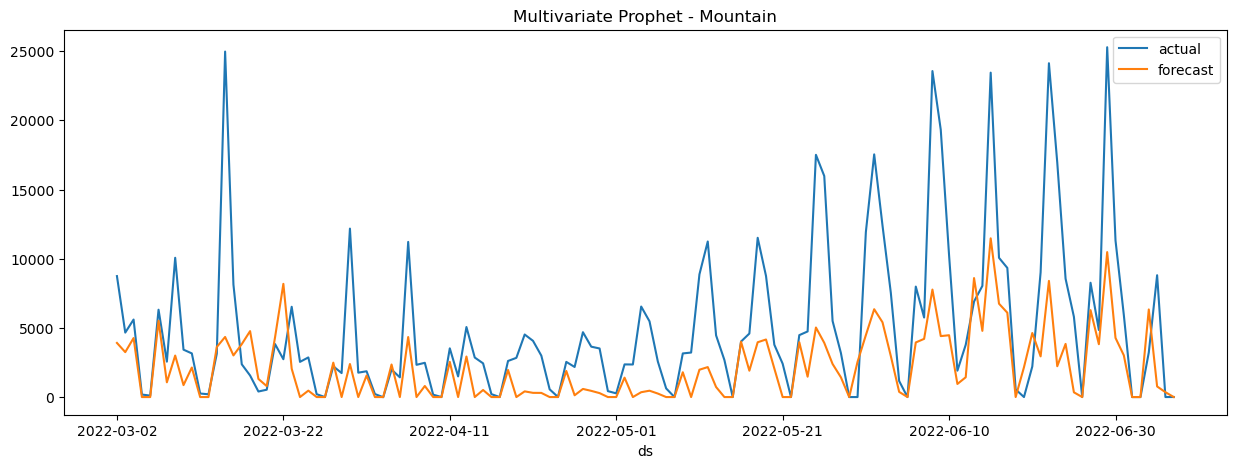

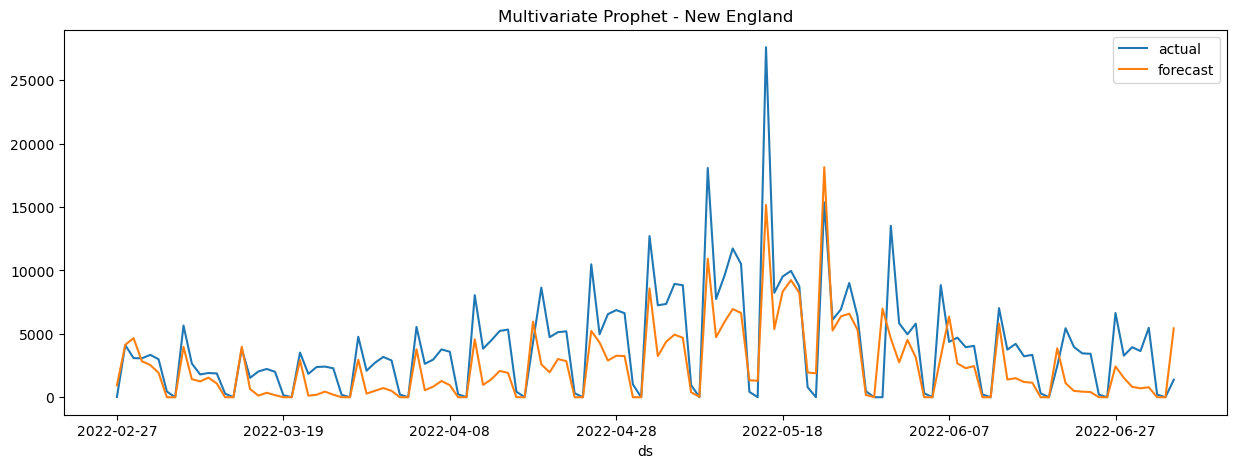

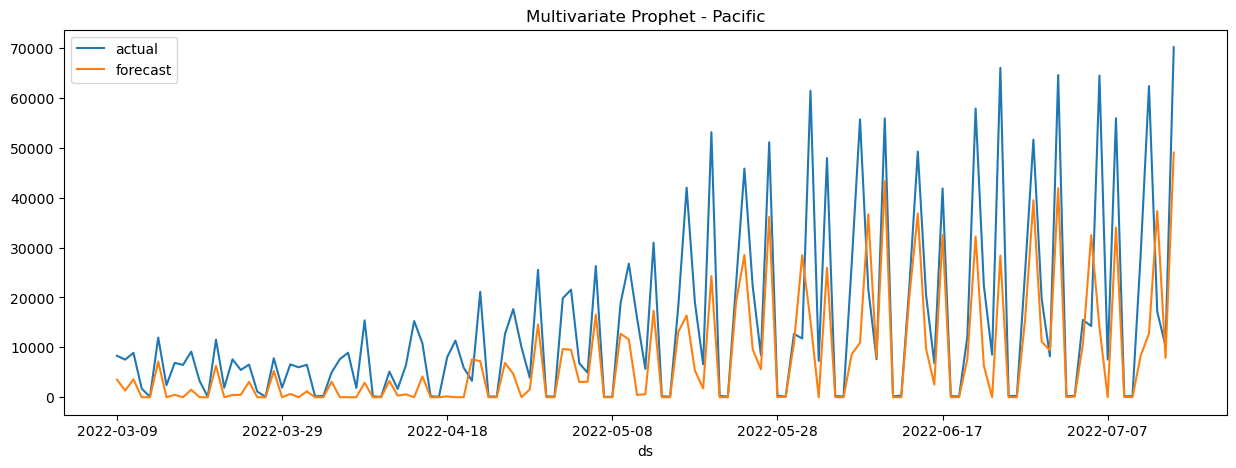

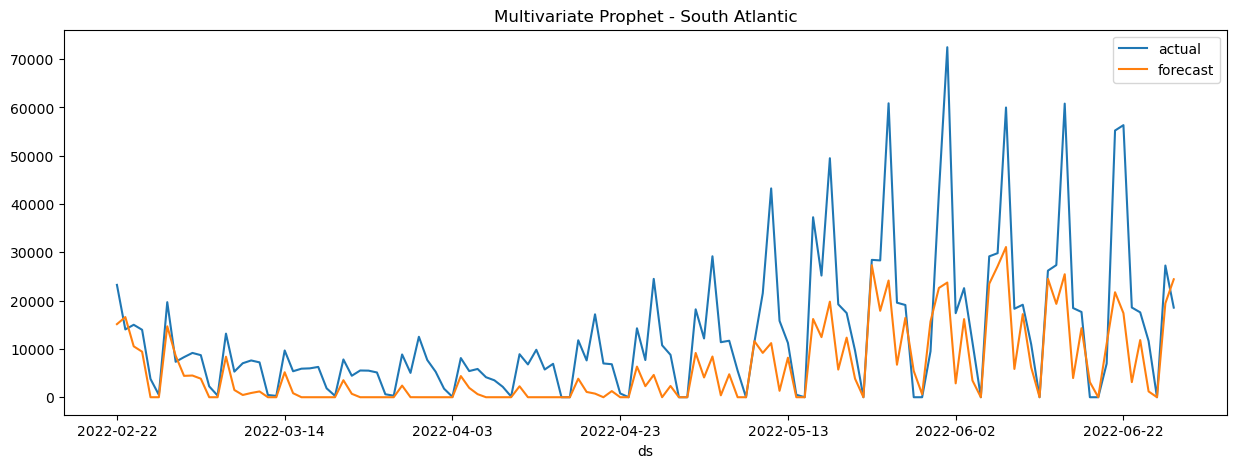

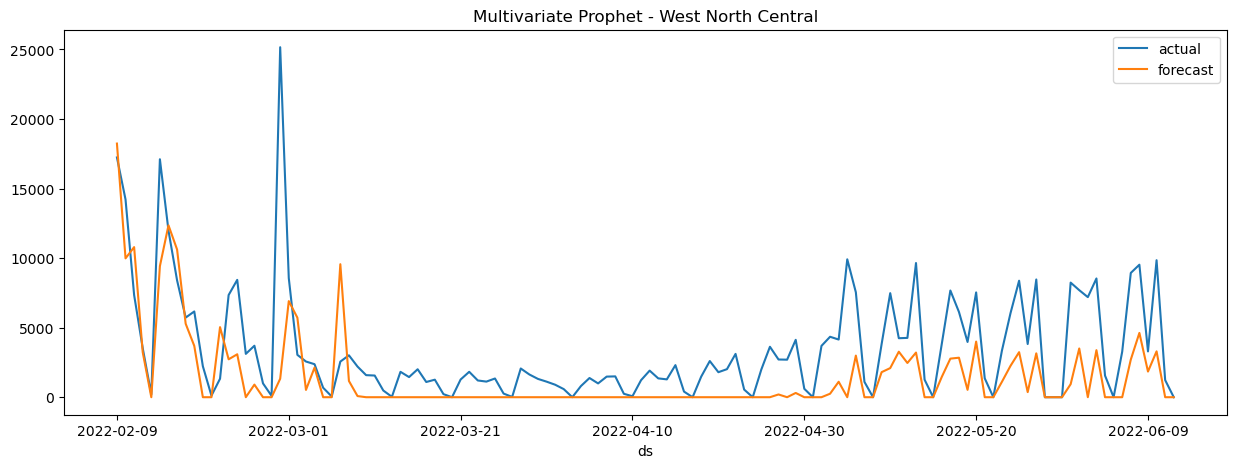

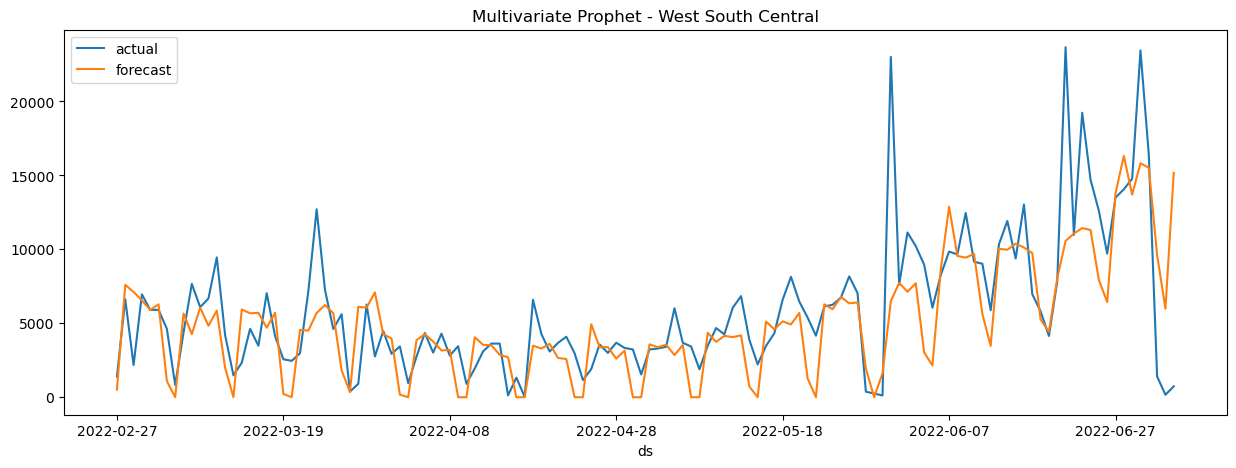

In [101]:
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.5)].drop('y'):
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model.add_country_holidays(country_name = 'US')
    model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    pd.DataFrame({'New Cases': test.reset_index().y, 'Predicted New Cases': test_pred.yhat}).set_index(test.ds).plot(figsize = (15,5))
    # pd.concat([pd.concat([train.reset_index().y,train_pred.reset_index().yhat], axis=1),
    #         pd.concat([test.reset_index().y,test_pred.reset_index().yhat], axis=1)],
    #         axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])
    print("MASE: ", mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
    print("Train MASE: ", mean_absolute_scaled_error(train.y, train_pred.yhat, y_train = train.y))
    print('RMSE: ', mean_squared_error(test.reset_index().y, test_pred.yhat, squared = False))
    print('MAE: ', mean_absolute_error(test.reset_index().y, test_pred.yhat))
    plt.legend(['actual', 'forecast'])
    plt.title('Multivariate Prophet - '+ data1.region.unique()[0])

## Finding Best Correlation Threshold

In [87]:
best = dict()
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    mases = []
    print(data1.region.unique()[0])
    thresholds = np.linspace(0.5, 0.8, num = 10)
    for th in thresholds:
        data = process(data1)
        data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
        size = round(data.shape[0]*0.1)
        train = data.iloc[:-size*2]
        val = data.iloc[-size*2:-size]
        trainval = data.iloc[:-size]
        test = data.iloc[-size:].reset_index().drop(columns = 'index')
        model = prophet.Prophet()
        for col in train.drop(columns = 'ds').columns[(abs(trainval.drop(columns = 'ds').corr().y) > th)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        train_pred = model.predict(train)
        val_pred = model.predict(val)
        mases.append(mean_absolute_scaled_error(val.y, val_pred.yhat, y_train = train.y))
        # plt.legend(['actual', 'forecast'])
        # plt.title(data1.region.unique()[0])
    # print(np.min(mases))
    # print(thresholds[np.argmin(mases)])
    best[data1.region.unique()[0]] = [np.min(mases), thresholds[np.argmin(mases)]]

20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing


East North Central


20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
20:20:54 - cmdstanpy - INFO - Chain [1] start processing
20:20:54 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1] done processing
20:20:55 - cmdstanpy - INFO - Chain [1] start processing
20:20:55 - cmdstanpy - INFO - Chain [1]

East South Central


20:20:56 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:56 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:56 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:56 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:56 - cmdstanpy - INFO - Chain [1] start processing
20:20:56 - cmdstanpy - INFO - Chain [1] done processing
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1] done processing
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1] done processing
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1] done processing
20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1]

Mid-Atlantic


20:20:57 - cmdstanpy - INFO - Chain [1] start processing
20:20:57 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:58 - cmdstanpy - INFO - Chain [1] done processing
20:20:58 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1]

Mountain


20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:00 - cmdstanpy - INFO - Chain [1] done processing
20:21:00 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] 

New England


20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:01 - cmdstanpy - INFO - Chain [1] start processing
20:21:01 - cmdstanpy - INFO - Chain [1] done processing
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1]

Pacific


20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:02 - cmdstanpy - INFO - Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:03 - cmdstanpy - INFO - Chain [1] start processing
20:21:03 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:04 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] 

South Atlantic


20:21:04 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:04 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:04 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:04 - cmdstanpy - INFO - Chain [1] done processing
20:21:04 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:05 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:05 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:05 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:05 - cmdstanpy - INFO - Chain [1] start processing
20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:05 - cmdstanpy - INFO - Chain [1] 

West North Central


20:21:05 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] 

West South Central


20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing


## Parameter Tuning

21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1] done processing
21:07:29 - cmdstanpy - INFO - Chain [1] start processing
21:07:29 - cmdstanpy - INFO - Chain [1]

East North Central
MASE:  0.5206886701390037
Train MASE:  0.536697619894884
RMSE:  5409.943755767849
MAE:  4513.4650701673345
Best Parameters:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1}


21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - ERROR - Chain [1] error: error

East South Central
MASE:  0.8963914845885769
Train MASE:  1.017071355816234
RMSE:  5231.757529259287
MAE:  3250.2403100775196
Best Parameters:  {'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.5}


21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:42 - cmdstanpy - INFO - Chain [1] done processing
21:07:42 - cmdstanpy - INFO - Chain [1] start processing
21:07:43 - cmdstanpy - INFO - Chain [1]

Mid-Atlantic
MASE:  1.643269280718376
Train MASE:  0.8448570284317711
RMSE:  5137.173782914869
MAE:  3751.1786722495685
Best Parameters:  {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10}


21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing
21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing
21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing
21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing
21:07:56 - cmdstanpy - INFO - Chain [1] start processing
21:07:56 - cmdstanpy - INFO - Chain [1] done processing
21:07:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing
21:07:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing
21:07:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1] done processing
21:07:57 - cmdstanpy - INFO - Chain [1] start processing
21:07:57 - cmdstanpy - INFO - Chain [1]

Mountain
MASE:  0.981611902663928
Train MASE:  0.8260839309526103
RMSE:  5086.798175598886
MAE:  3280.7137442608964
Best Parameters:  {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5}


21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:09 - cmdstanpy - INFO - Chain [1] start processing
21:08:09 - cmdstanpy - INFO - Chain [1] done processing
21:08:09 - cmdstanpy - INFO - Chain [1] start processing
21:08:09 - cmdstanpy - INFO - Chain [1]

New England
MASE:  0.4857841364918256
Train MASE:  0.6654995708539593
RMSE:  2185.923772143827
MAE:  1314.8013791091503
Best Parameters:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:16 - cmdstanpy - INFO - Chain [1] done processing
21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:16 - cmdstanpy - INFO - Chain [1] done processing
21:08:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:17 - cmdstanpy - INFO - Chain [1] done processing
21:08:17 - cmdstanpy - INFO - Chain [1] start processing
21:08:17 - cmdstanpy - INFO - Chain [1] done processing
21:08:17 - cmdstanpy - ERROR - Chain [1] error: error

Pacific
MASE:  0.8783170486763844
Train MASE:  0.6685427135669776
RMSE:  10521.329087678938
MAE:  6300.944516836707
Best Parameters:  {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1]

South Atlantic
MASE:  0.46546047487369163
Train MASE:  0.7129376663696219
RMSE:  8610.596671124476
MAE:  5396.304654836833
Best Parameters:  {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.25}


21:08:35 - cmdstanpy - INFO - Chain [1] start processing
21:08:35 - cmdstanpy - INFO - Chain [1] done processing
21:08:35 - cmdstanpy - INFO - Chain [1] start processing
21:08:35 - cmdstanpy - INFO - Chain [1] done processing
21:08:35 - cmdstanpy - INFO - Chain [1] start processing
21:08:35 - cmdstanpy - INFO - Chain [1] done processing
21:08:35 - cmdstanpy - INFO - Chain [1] start processing
21:08:35 - cmdstanpy - INFO - Chain [1] done processing
21:08:35 - cmdstanpy - INFO - Chain [1] start processing
21:08:36 - cmdstanpy - INFO - Chain [1] done processing
21:08:36 - cmdstanpy - INFO - Chain [1] start processing
21:08:36 - cmdstanpy - INFO - Chain [1] done processing
21:08:36 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:08:37 - cmdstanpy - INFO - Chain [1] start process

West North Central
MASE:  0.8635202069892439
Train MASE:  0.9868179833264419
RMSE:  4532.7690119538875
MAE:  2963.9845912186365
Best Parameters:  {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 0.5}


21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:47 - cmdstanpy - INFO - Chain [1] done processing
21:08:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


West South Central
MASE:  1.2494473982706693
Train MASE:  0.9507323113192399
RMSE:  6873.156555665569
MAE:  6068.44124195449
Best Parameters:  {'changepoint_prior_scale': 0.005, 'seasonality_prior_scale': 5}


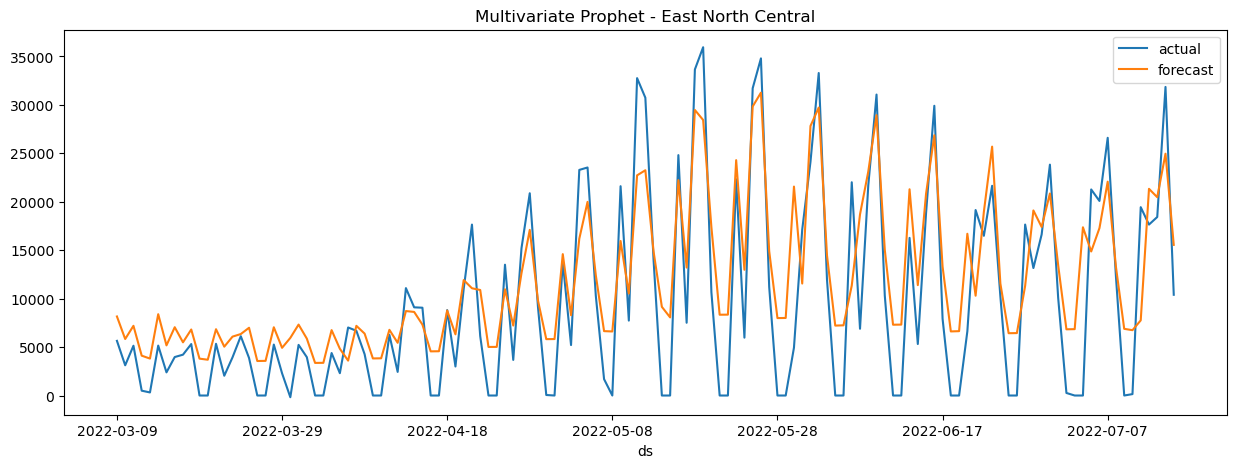

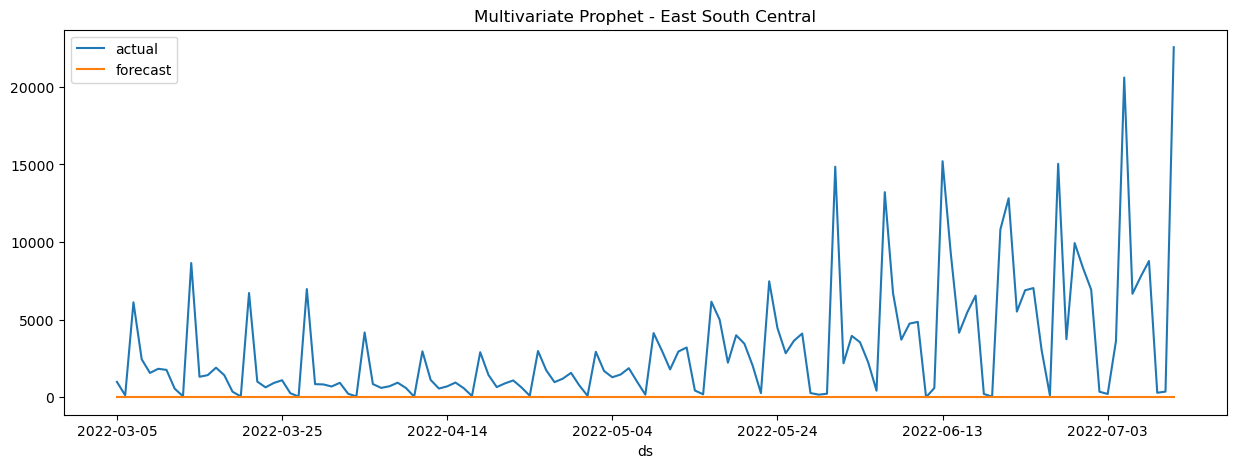

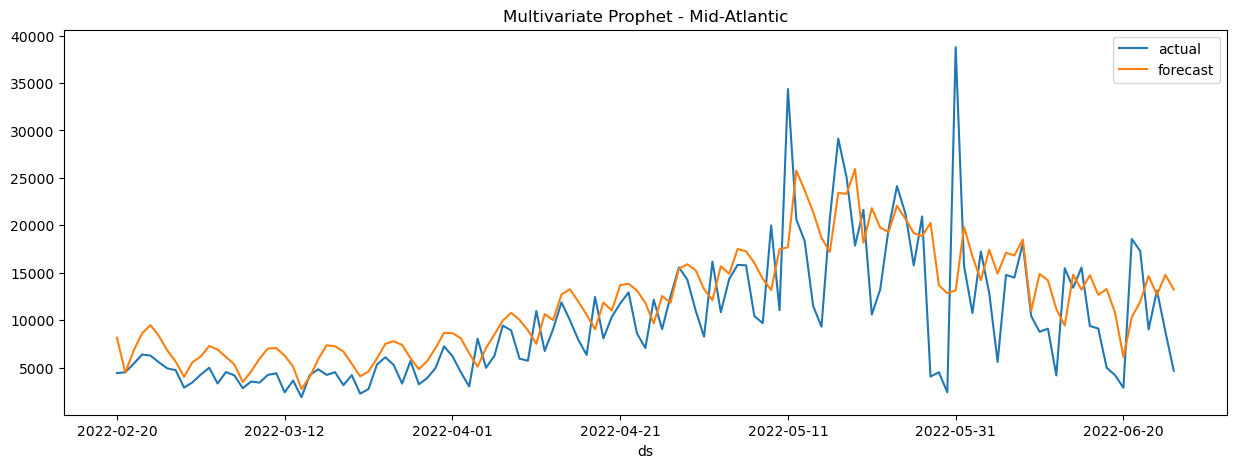

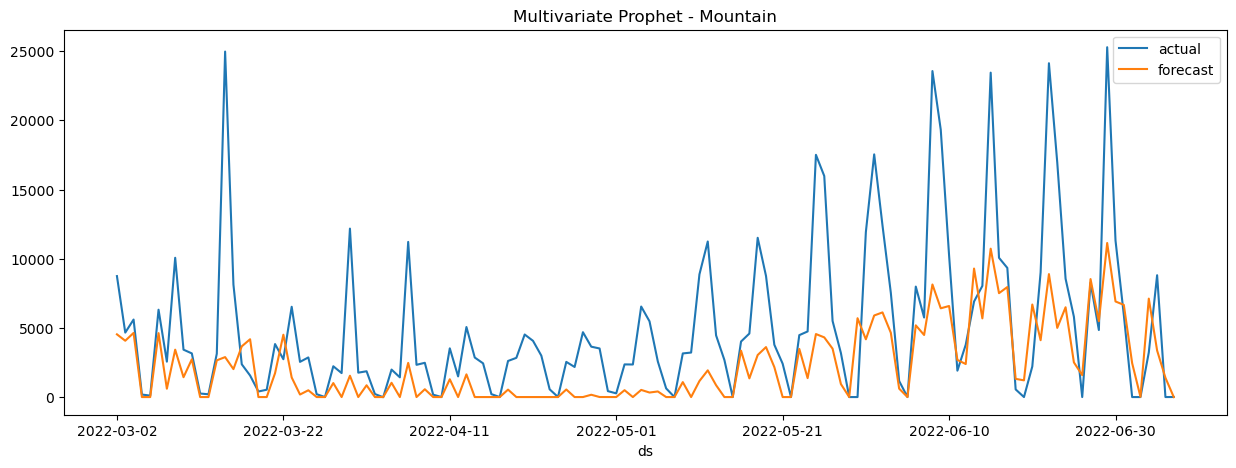

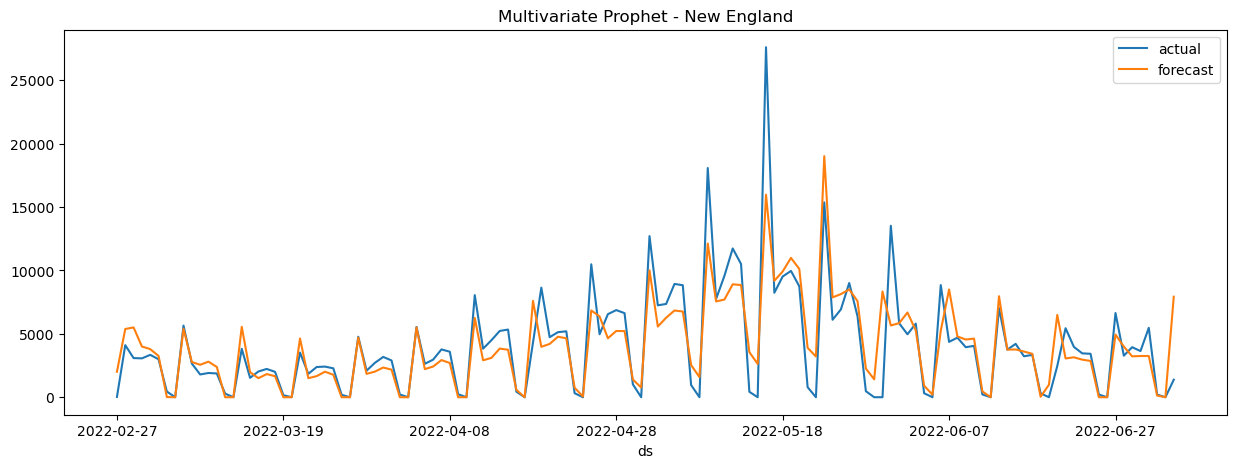

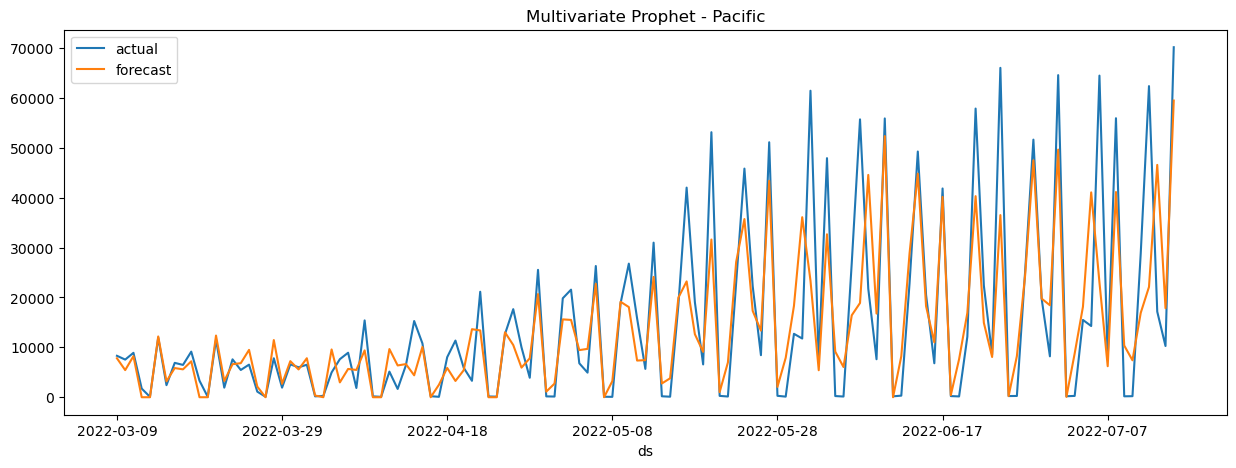

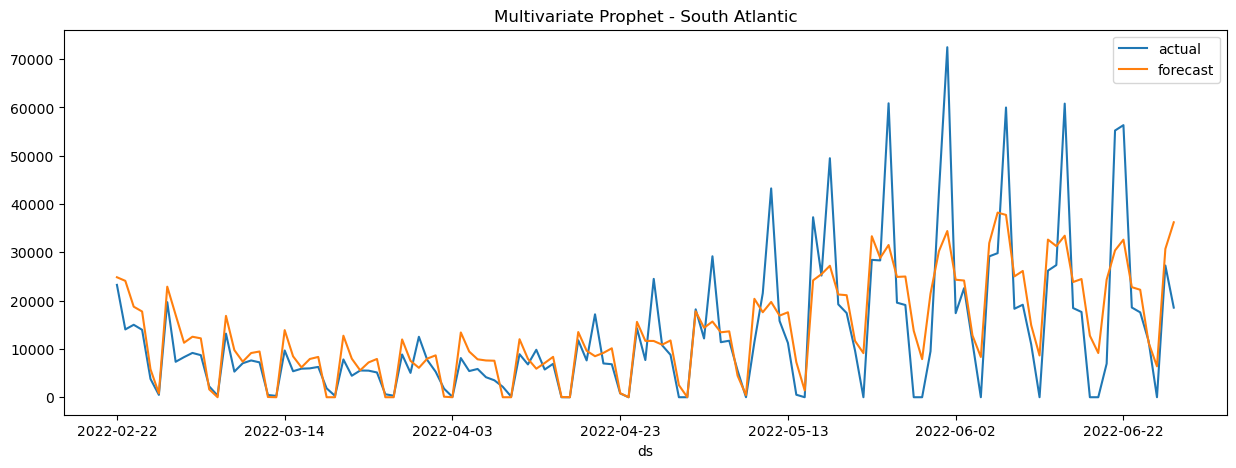

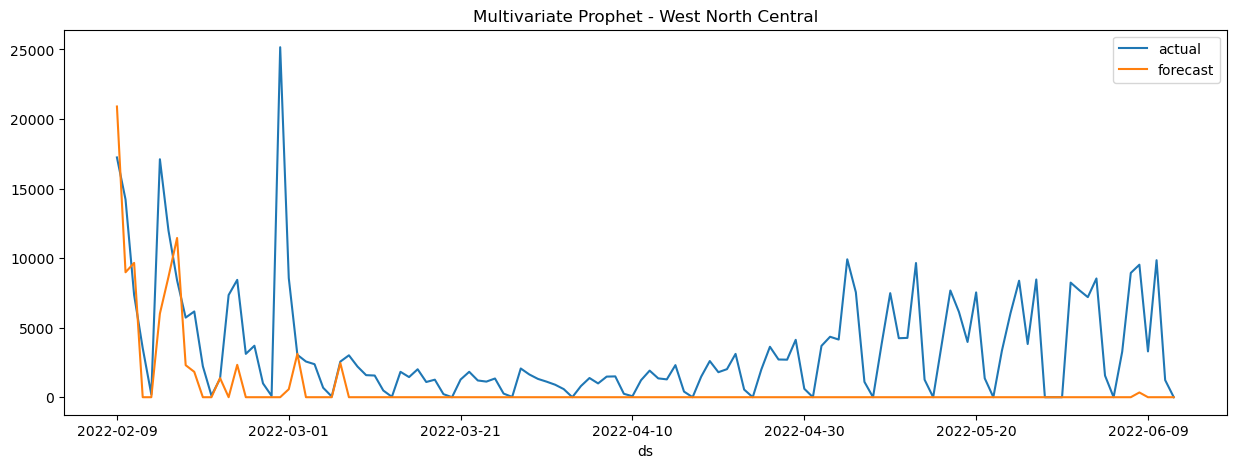

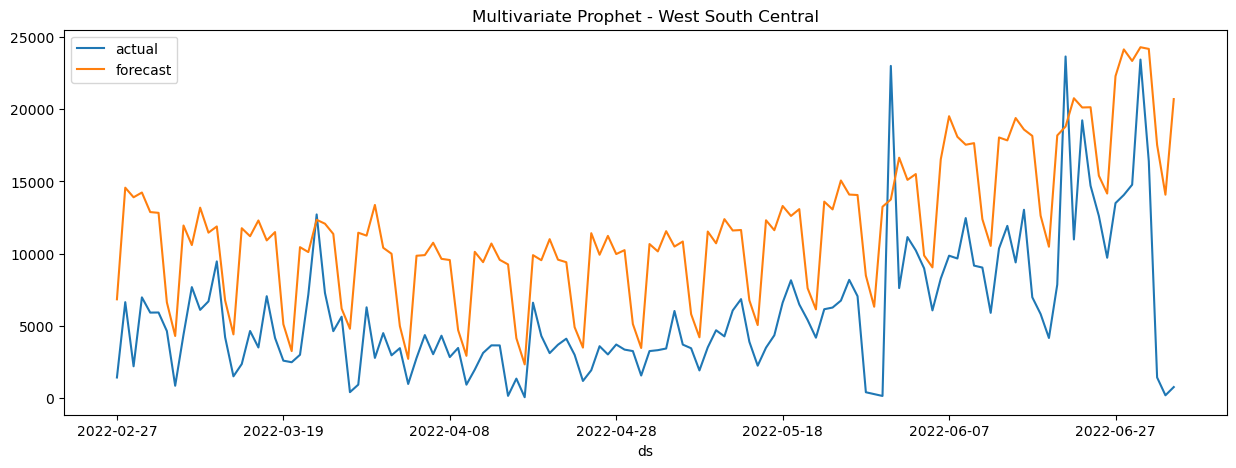

In [94]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import random
params_grid = {'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
    'seasonality_prior_scale':[0.1,0.25,0.5,1,5,10]}
grid = ParameterGrid(params_grid)
best_params = []
best_mase = []
best_rmse = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size*2]
    val = data.iloc[-size*2:-size]
    trainval = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    mases = []
    params = []
    rmses = []
    for p in grid:
        params.append(p)
        model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                seasonality_prior_scale=p['seasonality_prior_scale'])
        model.add_country_holidays(country_name='US')
        for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > best[data1.region.unique()[0]][1])].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col, standardize = False)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        val_pred = model.predict(val)
        masetemp = mean_absolute_scaled_error(val.y, val_pred.yhat, y_train = train.y)
        mases.append(masetemp)
    best_mase.append(min(mases))
    best_params.append(params[np.argmin(mases)])
    model = prophet.Prophet(changepoint_prior_scale=params[np.argmin(mases)]['changepoint_prior_scale'],
                            seasonality_prior_scale=params[np.argmin(mases)]['seasonality_prior_scale'])
    model.add_country_holidays(country_name='US')
    for col in trainval.drop(columns = 'ds').columns[(abs(trainval.drop(columns = 'ds').corr().y) > 0.6)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col, standardize = False)
    model = model.fit(trainval)
    train_pred = model.predict(trainval)
    test_pred = model.predict(test)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    pd.DataFrame({'New Cases': test.y, 'Predicted New Cases': test_pred.yhat}).set_index(test.ds).plot(figsize = (15,5))
    # pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
    #            pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
    #            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])
    print("MASE: ", mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = trainval.y))
    print("Train MASE: ", mean_absolute_scaled_error(trainval.y, train_pred.yhat, y_train = trainval.y))
    print('RMSE: ', mean_squared_error(test.reset_index().y, test_pred.yhat, squared = False))
    print('MAE: ', mean_absolute_error(test.reset_index().y, test_pred.yhat))
    print('Best Parameters: ', params[np.argmin(mases)])
    plt.legend(['actual', 'forecast'])
    plt.title("Multivariate Prophet - " + data1.region.unique()[0])
